# Imports, Load data

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import joblib
import os

from scipy import stats

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

sns.set_theme(context='talk', style='darkgrid', palette='magma')

# global random_state
random_state = 9

In [2]:
# set up GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv('../train_data/cleaned_data.csv')
df.shape

,player,player_game_count,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,completions,def_gen_pressures,dropbacks,drops,first_downs,grades_hands_fumble,grades_offense,grades_pass,grades_run,hit_as_threw,interceptions,passing_snaps,penalties,sacks,scrambles,spikes,thrown_aways,touchdowns,turnover_worthy_plays,yards,year,exp,target
0,A.J. Feeley,2,36,38,8.4,2.28,1,1,26,10,40,3,15,79.5,64.3,66.7,55.7,0,0,44,2,1,1,0,1,3,1,342,2006,5,41.2
1,A.J. Feeley,3,97,103,10.5,2.76,2,4,59,27,111,7,35,67.1,41.2,42.2,50.4,0,8,114,0,3,5,0,4,5,9,681,2007,6,50.0
2,A.J. McCarron,6,106,119,8.9,2.76,1,5,79,53,139,7,48,66.5,69.7,72.5,44.5,2,2,147,1,12,8,0,10,6,2,854,2015,0,37.1
3,A.J. McCarron,2,12,14,8.1,3.11,0,0,7,5,15,0,3,73.9,37.1,38.0,NaN,1,0,16,0,1,0,0,1,0,0,66,2017,1,37.2
4,A.J. McCarron,1,1,3,6.0,3.60,0,0,1,3,4,0,0,18.7,37.2,54.2,40.9,0,0,4,0,1,0,0,2,0,0,8,2018,2,58.8


- 830 QB seasons where we have at least 3 seasons for each player

# Define sequences
- df is already grouped by players and sorted by experience ascending

In [7]:
# check
df.head(50)

,player,player_game_count,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,completions,def_gen_pressures,dropbacks,drops,first_downs,grades_hands_fumble,grades_offense,grades_pass,grades_run,hit_as_threw,interceptions,passing_snaps,penalties,sacks,scrambles,spikes,thrown_aways,touchdowns,turnover_worthy_plays,yards,year,exp,target
0,A.J. Feeley,2,36,38,8.4,2.28,1,1,26,10,40,3,15,79.5,64.3,66.7,55.7,0,0,44,2,1,1,0,1,3,1,342,2006,5,41.2
1,A.J. Feeley,3,97,103,10.5,2.76,2,4,59,27,111,7,35,67.1,41.2,42.2,50.4,0,8,114,0,3,5,0,4,5,9,681,2007,6,50.0
2,A.J. McCarron,6,106,119,8.9,2.76,1,5,79,53,139,7,48,66.5,69.7,72.5,44.5,2,2,147,1,12,8,0,10,6,2,854,2015,0,37.1
3,A.J. McCarron,2,12,14,8.1,3.11,0,0,7,5,15,0,3,73.9,37.1,38.0,NaN,1,0,16,0,1,0,0,1,0,0,66,2017,1,37.2
4,A.J. McCarron,1,1,3,6.0,3.60,0,0,1,3,4,0,0,18.7,37.2,54.2,40.9,0,0,4,0,1,0,0,2,0,0,8,2018,2,58.8
5,A.J. McCarron,2,32,37,8.4,3.28,0,0,21,17,47,0,14,80.0,58.8,54.9,69.8,0,1,47,0,5,5,0,5,0,0,225,2019,3,64.1
6,Aaron Rodgers,2,15,15,11.1,3.19,0,0,6,10,20,0,3,27.1,30.3,29.3,63.0,0,0,21,0,3,2,0,0,0,1,46,2006,1,66.1
7,Aaron Rodgers,2,26,28,6.7,2.56,1,0,20,12,35,0,12,79.2,66.1,62.4,68.7,0,0,37,0,3,4,1,0,1,0,218,2007,2,79.1
8,Aaron Rodgers,16,496,536,9.3,0.00,6,29,341,164,600,43,194,73.4,79.1,80.5,48.6,6,13,626,6,34,30,5,23,28,18,4045,2008,3,87.8
9,Aaron Rodgers,16,509,541,9.3,0.00,9,25,350,193,625,45,217,55.3,87.8,87.2,61.3,6,7,665,4,50,34,3,14,30,11,4434,2009,4,88.1


In [8]:
# keep QBs with more than 2 seasons
df = df.groupby('player').filter(lambda x: len(x) > 2)

(830, 31)

In [6]:
seasons_per_player.mean(), np.median(seasons_per_player)

(4.444954128440367, 3.0)

- For the players with only a single season, we'll have to use a dense network
- First iteration of the sequential model will use 2 seasons to predict the third. This means we have to drop players with under 3 seasons in the dataset.

In [9]:
seasons_per_player = []

for key, val in df.groupby('player').groups.items():
    seasons_per_player.append(len(val))
    
# convert to numpy array
seasons_per_player = np.array(seasons_per_player)
np.sort(seasons_per_player)

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13,
       14, 14, 14, 14, 15, 16, 16])

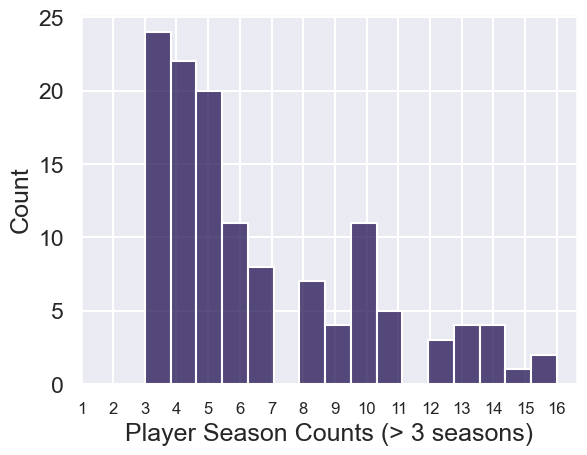

In [10]:
sns.histplot(seasons_per_player, bins=16)

plt.xlabel('Player Season Counts (> 3 seasons)')

plt.xticks(list(range(1, 17)), fontsize=12);

# Get data ready for modeling

### Less features on first iteration
- Doing this for simplicity and to make the evaluation process easier

In [11]:
df2.columns

Index(['player', 'player_game_count', 'aimed_passes', 'attempts',
       'avg_depth_of_target', 'avg_time_to_throw', 'bats', 'big_time_throws',
       'completions', 'def_gen_pressures', 'dropbacks', 'drops', 'first_downs',
       'grades_hands_fumble', 'grades_offense', 'grades_pass', 'grades_run',
       'hit_as_threw', 'interceptions', 'passing_snaps', 'penalties', 'sacks',
       'scrambles', 'spikes', 'thrown_aways', 'touchdowns',
       'turnover_worthy_plays', 'yards', 'year', 'exp', 'target'],
      dtype='object')

In [12]:
cols_to_drop = ['year', 'target']

In [13]:
# drop columns
df2 = df2.drop(cols_to_drop, axis=1)

### Nulls

In [14]:
df2.isna().sum().to_frame().T

,player,player_game_count,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,completions,def_gen_pressures,dropbacks,drops,first_downs,grades_hands_fumble,grades_offense,grades_pass,grades_run,hit_as_threw,interceptions,passing_snaps,penalties,sacks,scrambles,spikes,thrown_aways,touchdowns,turnover_worthy_plays,yards,exp
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0


- very few nulls.
- 1 in average_depth_of_target and 34 in grades_run (QBs with no rushing attempts for that season)
- Since null values are rare, I will fill these cells with 0

In [15]:
# fill nulls with 0
df2 = df2.fillna(0)

In [16]:
# check
df2.isna().sum().to_frame().T

,player,player_game_count,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,completions,def_gen_pressures,dropbacks,drops,first_downs,grades_hands_fumble,grades_offense,grades_pass,grades_run,hit_as_threw,interceptions,passing_snaps,penalties,sacks,scrambles,spikes,thrown_aways,touchdowns,turnover_worthy_plays,yards,exp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Pack data into proper sequences

In [17]:
# create a new DataFrame to hold sequences
sequences = []
labels = []

# iterate over each player
for player, group in df2.groupby('player'):
    # iterate over the group to create sequences
    for i in range(len(group) - 2):
        # each sequence is a list of rows/features from two consecutive seasons
        sequence = group.iloc[i:i+2].drop('player', axis=1).to_dict('records')
        
        # The label is the 'grades_offense' from the third season
        label = group.iloc[i+2]['grades_offense']
        
        sequences.append(sequence)
        labels.append(label)

# unpack the dicts in each sequence, fill null values with 0
unpacked_sequences = [
    [[val for val in list(d.values())] for d in sequence] 
    for sequence in sequences
]        

# convert sequences and labels into a tensor
X = np.array(unpacked_sequences)
y = np.array(labels)

In [18]:
X.shape, y.shape

((578, 2, 28), (578,))

- Data for X is in the format (pair_of_seasons, sequence_length, num_features)

### Split data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((462, 2, 28), (116, 2, 28), (462,), (116,))

### Standardize the data

In [27]:
# StandardScaler won't accept 3-dimensional data as input, so we create a function
def standardize_3d(X_train, X_test):
    '''
    
    Reshapes X array from 3D to 2D and standardizes.
    
    Parameters
    - X_train: (np.array) X_train array.
    - X_test: (np.array) X_test array.
    
    Returns
    - X_train_standardized: (np.array) standardized X_train array.
    - X_test_standardized: (np.array) standardized X_test array.
    
    '''
    
    # reshape the data to be 2D -> (n_samples * n_time_steps, n_features)
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    
    # create scaler, fit on the training data
    scaler = StandardScaler()
    scaler.fit(X_train_reshaped)
    
    # transform the data
    X_train_standardized_2d = scaler.transform(X_train_reshaped)
    X_test_standardized_2d = scaler.transform(X_test_reshaped)
    
    # reshape back to 3D
    X_train_standardized_3d = X_train_standardized_2d.reshape(X_train.shape)
    X_train_standardized_3d = X_test_standardized_2d.reshape(X_test.shape)
    
    return X_train_standardized_3d, X_train_standardized_3d



# Standardize the data
X_train_standardized, X_test_standardized = standardize_3d(X_train, X_test)

In [29]:
# convert sequences and labels into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).unsqueeze(-1)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([462, 2, 28]),
 torch.Size([116, 2, 28]),
 torch.Size([462, 1]),
 torch.Size([116, 1]))

In [80]:
# batch_size
batch_size = 16

# datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test_tensor.shape[0], shuffle=False)

In [81]:
for x, y in test_loader:
    print(x.shape, y.shape)

torch.Size([116, 2, 28]) torch.Size([116, 1])


# RNN

In [ ]:
# load in sequence_df before training
sequence_df = pd.read_csv('../model/sequence.csv')

In [82]:
class RNN_1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(RNN_1, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        
        return out

In [83]:
# hyperparameters
hidden_dim = 16
num_epochs = 1000

# model, loss, optimizer
model = RNN_1(input_dim=X_train_tensor.shape[-1], hidden_dim=hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [84]:
# early stopping
patience = 20
best_val_loss = float('inf')
epochs_without_improvement = 0

# training loop
for epoch in range(num_epochs):
    # training mode
    model.train()
    
    # sum of rmse, preds, and y
    sum_rmse = 0
    epoch_preds = []
    epoch_y = []
    
    # train batches
    for x, y in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        train_preds = model(x)
        # calc loss
        train_loss = criterion(train_preds, y)
        # backward pass
        train_loss.backward()
        # optimize
        optimizer.step()

        # get rmse for current batch, add to sum rmse
        sum_rmse += np.sqrt(train_loss.item())
        
        # get preds and y from batch to calc r2
        epoch_preds.extend(train_preds.numpy(force=True))
        epoch_y.extend(y.numpy(force=True))
    
    # train metrics
    train_rmse = sum_rmse / len(train_dataset)
    train_r2 = r2_score(epoch_y, epoch_preds)
    
    # set model to eval mode
    model.eval()

    with torch.inference_mode():
        # test loop (single batch)
        for x, y in test_loader:
            # forward pass
            test_preds = model(x)
            # calc loss
            test_loss = criterion(test_preds, y)

            # test metrics
            test_rmse = np.sqrt(test_loss.item())
            test_r2 = r2_score(y.numpy(force=True), test_preds.numpy(force=True))
    
    # print metrics
    if (epoch+1) % 1e2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train RMSE: {train_rmse:.4f}')
        print(f'Train R2: {train_r2:.4f}')
        print(f'Test RMSE: {test_rmse:.4f}')
        print(f'Test R2: {test_r2:.4f}')
        print()

Epoch [100/1000]
Train RMSE: 0.9539
Train R2: -0.0923
Test RMSE: 13.5978
Test R2: -0.1708

Epoch [200/1000]
Train RMSE: 0.7841
Train R2: 0.2602
Test RMSE: 13.7069
Test R2: -0.1897

Epoch [300/1000]
Train RMSE: 0.7903
Train R2: 0.2458
Test RMSE: 13.5690
Test R2: -0.1659

Epoch [400/1000]
Train RMSE: 0.7222
Train R2: 0.3733
Test RMSE: 12.7531
Test R2: -0.0299

Epoch [500/1000]
Train RMSE: 0.6962
Train R2: 0.4148
Test RMSE: 12.0518
Test R2: 0.0803

Epoch [600/1000]
Train RMSE: 0.6970
Train R2: 0.4004
Test RMSE: 12.7542
Test R2: -0.0301

Epoch [700/1000]
Train RMSE: 0.6746
Train R2: 0.4460
Test RMSE: 12.8083
Test R2: -0.0388

Epoch [800/1000]
Train RMSE: 0.6974
Train R2: 0.4045
Test RMSE: 12.3500
Test R2: 0.0342

Epoch [900/1000]
Train RMSE: 0.6552
Train R2: 0.4610
Test RMSE: 12.6247
Test R2: -0.0092

Epoch [1000/1000]
Train RMSE: 0.6661
Train R2: 0.4570
Test RMSE: 12.7369
Test R2: -0.0273



In [72]:
model.children()

TypeError: 'generator' object is not subscriptable

In [78]:
for child in model.children():
    print(child)

RNN(28, 32, num_layers=2, batch_first=True)
Linear(in_features=32, out_features=1, bias=True)


In [77]:
for child in RNN_1.children(model):
    print(child)

RNN(28, 32, num_layers=2, batch_first=True)
Linear(in_features=32, out_features=1, bias=True)


# Results df
- Dataframe to store all results from sequence models.
- Stores NN type, hyperparams, and performance metrics.

In [ ]:
# empty df to store NN results and params
keras_df = pd.DataFrame(columns=['train_rmsle', 'test_rmsle', 'num_layers', 'shape', 'optim', 'epochs', 'batch_size'])
keras_df

In [ ]:
# fit pipeline, return pipeline metrics
def fit_eval(layers, results_df=keras_df, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):

    '''
    
    Parameters:
    layers - a list containing node counts for hidden layers

    Returns:
    results_df - df passed in with the results appended from the pipeline passed in, params of nn also included
    
    '''
    
    # add early stopping -> if model doesn't decrease val_loss every 5 epochs, exit the fitting process
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    # create the KerasRegressor
    nn = KerasRegressor(build_model(layers), random_state=0, verbose=0, callbacks=[early_stopping], loss=rmsle, 
                         optimizer=Adam(), epochs=1000, batch_size=32, validation_split=0.2)
    
    # create pipeline
    pipeline = Pipeline([
        ('ct', ct),
        ('nn', nn)
    ])
    
    # fit pipeline
    pipeline.fit(X_train, y_train)
    
    # make predictions
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)
    
    # log root-mean-squared-logarithmic-error
    train_loss = rmsle(y_train, train_preds).numpy()
    test_loss = rmsle(y_test, test_preds).numpy()


    
#     # get KerasClassifier object
#     nn = pipeline.named_steps['nn']

    # get number of layers
    num_layers = len(nn.model.layers)

    # get shape of nn
    nn_shape = []
    for i, layer in enumerate(nn.model.layers):
        if i % 2 == 0:
            nn_shape.append(layer.units)

    # get optimizer
    optim = str(nn.optimizer).split()[0].split('.')[-1]

    # get epochs
    epochs = nn.current_epoch

    # get epochs
    batch_size = nn.batch_size
    
    
    
    # append results to the df
    results_df.loc[len(results_df.index)] = [train_loss, test_loss, num_layers, nn_shape, optim, 
                                             epochs, batch_size]
    
    
    
    return results_df